# CS231a PSET 4 Problem 4: Linear Kalman Filter with a Learned Inverse Observation Model

Building on the idea of learning useful representations for downstream tasks we saw in the last problem, in this problem you will see how this can be done for the task of monocular depth estimation.

**Using a GPU**. Make sure to first change your runtime to use a GPU: click Runtime -> Change runtime type -> Hardware Accelerator -> GPU and your Colab instance will automatically be backed by GPU compute.

Note: there is a known issue of the RAM running out while loading the second set of data after training. To get around this, after training please just restart the runtime and rerun the first 3 cells (prior to loading the training data) followed by the cells under 'Using the model'.

In [1]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # enter the foldername in your Drive where you have saved the data
# # folder from the pset folder
# e.g. 'cs231a/ps4'
FOLDERNAME = 'ps4_code/ps4_code'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME

[Errno 2] No such file or directory: 'drive/My Drive'
/content
/content/ps4_code/ps4_code


In [2]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import gc
import time

# Loading the data for part A

Let's start by loading our datasets into memory:


In [3]:
def load_dataset(root, split="train"):
    labels = np.load(root + 'Q4A_positions_'+split+'.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images), desc='Loading data'):
        im = Image.open(root + 'img_%03d_%s.png'%(i,split))
        images[i] = np.array(im)/255.0
    return images, labels

image_train, label_train = load_dataset('data/Q4A_data/training_set/', 'train')
image_test, label_test = load_dataset('data/Q4A_data/testing_set/', 'test')

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading data:   0%|          | 0/100 [00:00<?, ?it/s]

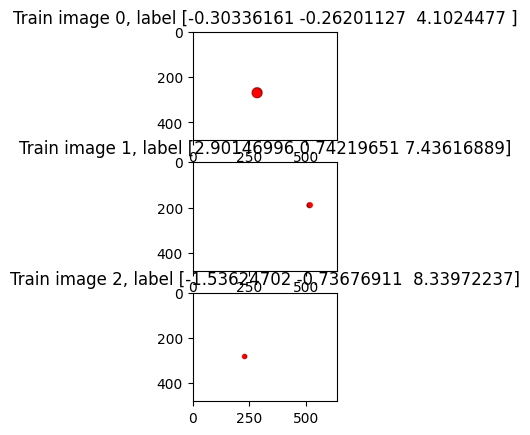

In [4]:
n = 3
fig, axs = plt.subplots(n)
for i in range(n):
    idx = i
    img = image_train[idx]
    axs[i].imshow(img)
    axs[i].set_title('Train image %d, label %s'%(idx,str(label_train[idx])))

# Training the Model

Next, we can go ahead and train the model:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ObservationModel(nn.Module):
    def __init__(self):
        super(ObservationModel, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.conv3_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 2, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.conv3_3(x)

        N, C, H, W = x.shape
        features = x.view(N, C, -1).permute(0, 2, 1).contiguous().view(-1, C)
        softmax = F.softmax(features, dim=1)
        softmax = softmax.view(N, H, W, C).permute(0, 3, 1, 2).unsqueeze(-1)

        posx, posy = torch.meshgrid(torch.linspace(-1., 1., H), torch.linspace(-1., 1., W), indexing='ij')
        posx = posx.view(1, 1, H, W, 1).to(x.device)
        posy = posy.view(1, 1, H, W, 1).to(x.device)
        image_coords = torch.cat([posx, posy], dim=-1)

        feature_points = torch.sum(softmax * image_coords, dim=[2, 3])
        feature_points = feature_points.view(N, C * 2)

        x = F.relu(self.bn_fc1(self.fc1(feature_points)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

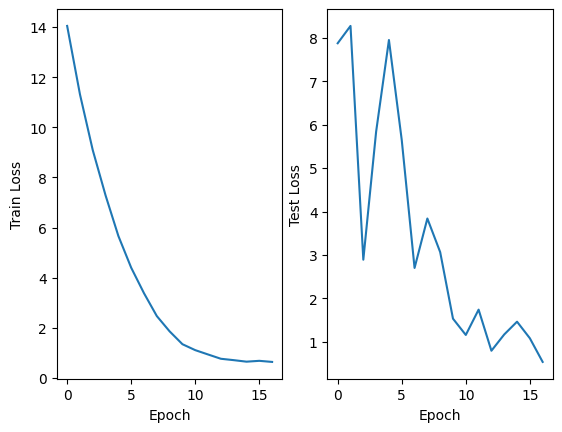

Final training loss:  0.6390715508706986
Final testing loss:  0.5395651374544416


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming make_model is a function that returns an instance of a PyTorch model
model = ObservationModel()
criterion = nn.MSELoss()
learning_rate = 2.8e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 16
num_epochs = 17

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# If using an M2/M3 Macbook, uncomment the following line
# device = torch.device("mps")

# Convert data to PyTorch tensors
image_train_tensor = torch.tensor(image_train, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
label_train_tensor = torch.tensor(label_train, dtype=torch.float32, device=device)
image_test_tensor = torch.tensor(image_test, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
label_test_tensor = torch.tensor(label_test, dtype=torch.float32, device=device)

# Create DataLoader for training and testing
train_dataset = TensorDataset(image_train_tensor, label_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(image_test_tensor, label_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
test_losses = []

model.to(device)

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    train_loss = 0.0
    for batch_image_train, batch_label_train in train_loader:
        batch_image_train, batch_label_train = batch_image_train, batch_label_train
        optimizer.zero_grad()
        predict = model(batch_image_train)
        loss = criterion(predict, batch_label_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_image_test, batch_label_test in test_loader:
            batch_image_test, batch_label_test = batch_image_test, batch_label_test
            predict = model(batch_image_test)
            loss = criterion(predict, batch_label_test)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    torch.save(model.state_dict(), 'trained_model.pth')
    if epoch > 1:
        clear_output()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(train_losses)
        ax2.plot(test_losses)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Train Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Test Loss')
        plt.show()

print("Final training loss: ", train_losses[-1])
print("Final testing loss: ", test_losses[-1])


In [8]:
# run if using Colab and want to save memory
%xdel image_train
%xdel image_test
gc.collect()

80553

# Using the Model

Now, let's use the model to make predictions for our Kalman Filter. Note that you may have to restart the runtime if your RAM runs out; just run the things up to 'Loading the data for part A' and then skip to this section.

In [9]:
def load_dataset():
    labels = np.load('./data/Q4B_data/Q4B_positions_gt.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images),desc="Loading data"):
        im = Image.open('./data/Q4B_data/img_%03d.png'%(i))
        images[i] = np.array(im)/255.0
    return images, labels

image_infer, label_infer = load_dataset()

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
model.eval()  # Set the model to evaluation mode

predictions_val = []
with torch.no_grad():  # Disable gradient calculation
    for img in image_infer:
        img_tensor = torch.tensor(img, device=device, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).float()  # Convert image to tensor and adjust dimensions
        pred_val = model(img_tensor)
        predictions_val.append(pred_val.squeeze().cpu().numpy())
predictions_val = np.array(predictions_val)
print('Mean error: ' + str(np.mean(np.linalg.norm(label_infer - predictions_val, axis=1))))
np.save('./data/Q4B_predictions.npy', predictions_val)


Mean error: 1.1271992147205168


In [11]:
# run if using Colab or want to save local memory

%xdel image_infer
gc.collect()

18

In [12]:
def load_dataset():
    labels = np.load('./data/Q4D_data/Q4D_positions_gt.npy')
    num_images = labels.shape[0]
    images = np.empty(shape=(num_images, 480, 640,3))
    for i in tqdm(range(num_images),desc="Loading data"):
        im = Image.open('./data/Q4D_data/img_%03d.png'%(i))
        images[i] = np.array(im)/255.0
    return images, labels

image_infer, label_infer = load_dataset()

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
import os
os.getcwd()

'/content/ps4_code/ps4_code'

In [14]:
model.eval()  # Set the model to evaluation mode

predictions_val = []
with torch.no_grad():  # Disable gradient calculation
    for img in image_infer:
        img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).cuda().float()  # Convert image to tensor and adjust dimensions
        pred_val = model(img_tensor)
        predictions_val.append(pred_val.squeeze().cpu().numpy())
predictions_val = np.array(predictions_val)
print('Mean error: ' + str(np.mean(np.linalg.norm(label_infer - predictions_val, axis=1))))
np.save('./data/Q4D_predictions.npy', predictions_val)


Mean error: 1.4748669785896513


# Finishing Problem 4
Now that you have the predictions .npy files, you can use these along with the completed code in p4.py to generate the plots needed for the PDF report. Congratulations on finishing the last 231a PSET!